In [1]:
import numpy as np
import pandas as pd
import cv2
from numpy import random, moveaxis
import os
import pyautogui
from win32api import GetSystemMetrics
import matplotlib.pyplot as plt

In [2]:
source = 'fer2013/sample_fer2013.csv'
sample = pd.read_csv(source)
print(sample.shape)
sample.head(20)

(13, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


9076
2304


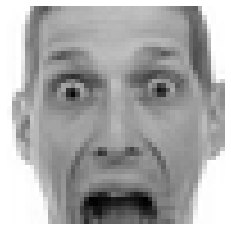

In [3]:
line = sample['pixels'][9]
print(len(line))
image_data = np.asarray([int(x) for x in line.split()])  # numpy array
print(len(image_data))
img = image_data.reshape((48,48)).astype('uint8')  # 2-d numpy array
# img = cv2.bitwise_not(img)  # w&b bitwise inverted or do not multiply by 255
    
# print(f'ID:{id} \n{clases[clase]}')
plt.imshow(img, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.show()

**New detections**

In [4]:
# face detector
protoPath = os.path.join('models', 'deploy.prototxt')
modelPath = os.path.join('models', 'res10_300x300_ssd_iter_140000.caffemodel')
detector = cv2.dnn.readNetFromCaffe(protoPath, modelPath)
threshold = 0.45  # to filter out week face detections
px_filter = 15  # size filter to ensure a sufficiently large face
divider = 1000  # every 100 fps (iterations) we save and c comes back to zero and then to start the counting again

In [11]:
VID = os.path.join('media', 'recording.avi')
webcam = cv2.VideoCapture(VID)
vectors = []  # pixels
emos = []  # emotion
Usage = []  # Usage

c = 1
while True:
    ret, frame = webcam.read()
    fps = webcam.get(cv2.CAP_PROP_POS_FRAMES)  # CAP_PROP_FS
    
    if ret is False:
        print('Ok. Finished')
        break
        
    if c%divider==0:  # c comes back to zero and then to start the counting again from 1
        
        frame = cv2.normalize(frame, None, 10, 245, cv2.NORM_MINMAX)
        (h_frame, w_frame) = frame.shape[:2]

        imageBlob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0, (300, 300), (104.0, 187.0, 123.), swapRB=False, crop=False)
        detector.setInput(imageBlob)
        detections = detector.forward()

        for i in range(0, detections.shape[2]):
            confidence = detections[0, 0, i, 2]

            if confidence > threshold:
                box = detections[0, 0, i, 3:7] * np.array([w_frame, h_frame, w_frame, h_frame])
                (startX, startY, endX, endY) = box.astype("int")  # x, y coordinates of the bounding box for the face
                (startX, startY, endX, endY) = (6+startX, 6+startY, 6+endX, 6+endY)  # offset for classification

                face = frame[startY:endY, startX:endX]
                face = cv2.resize(face, (300, 300), interpolation=cv2.INTER_AREA)
                (fH, fW) = face.shape[:2]
                # n1 = os.path.join('fer2013', 'us', str(i)+'_'+str(fps)+'_color.jpg')
                # cv2.imwrite(n1, face)

                if fW < px_filter or fH < px_filter:
                    continue

                gray = cv2.cvtColor(face, cv2.COLOR_RGB2GRAY)
                # cv2.imwrite('text2.jpg', gray)

                gray48 = cv2.resize(gray, (48, 48), interpolation=cv2.INTER_AREA)
                
                flat = np.array(gray48).flatten('C')  # vectorizing the image
                flat_str = ' '.join([str(elem) for elem in flat])  # convert the array vector to a string
                vectors.append(flat_str)
                emos.append('0')  # temporary emotion
                Usage.append('Training')  # all for training
                
                n2 = os.path.join('fer2013', 'us', str(i)+'_'+str(int(fps))+'.jpg')
                cv2.imwrite(n2, gray48)
    c+=1
            
webcam.release()
cv2.destroyAllWindows()

Ok. Finished


In [12]:
print(f'elements: {len(vectors)}')

elements: 34


In [13]:
print(len(vectors[0]))
# print(vectors[0])

6911


In [21]:
addon = {
    'emotion': emos,
    'pixels': vectors,
    'Usage': Usage,
}
addon_data = pd.DataFrame.from_dict(addon)
print(addon_data.shape[0])
addon_data.head(10)

34


,emotion,pixels,Usage
0,0,10 10 10 10 10 10 10 10 10 11 14 18 22 24 20 2...,Training
1,0,109 41 28 29 30 30 30 30 31 33 40 52 68 83 94 ...,Training
2,0,61 54 50 47 45 46 50 68 88 103 113 121 127 128...,Training
3,0,33 33 33 33 31 30 31 32 33 37 39 38 38 37 38 3...,Training
4,0,16 17 19 24 25 29 29 39 32 27 31 39 47 63 81 1...,Training
5,0,105 73 75 110 129 146 150 142 133 121 114 115 ...,Training
6,0,24 16 20 25 22 16 17 23 30 35 34 39 42 51 57 7...,Training
7,0,58 50 46 47 46 45 52 72 91 106 118 124 128 128...,Training
8,0,10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 1...,Training
9,0,115 117 90 110 118 126 132 133 134 131 125 117...,Training


0
6911
2304


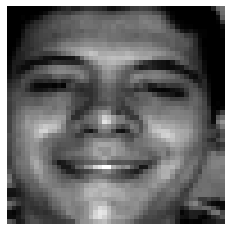

1
1
8022
2304


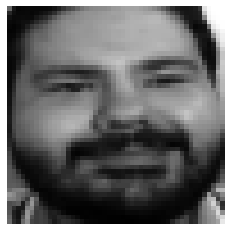

1
2
8028
2304


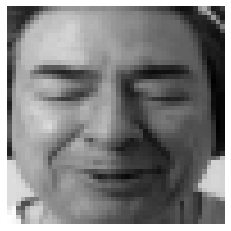

1
3
8179
2304


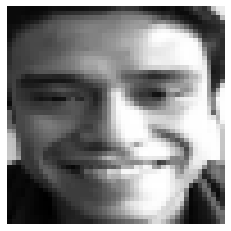

1
4
8251
2304


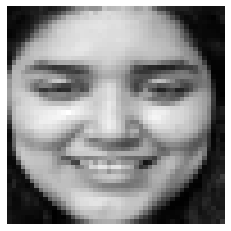

1
5
8649
2304


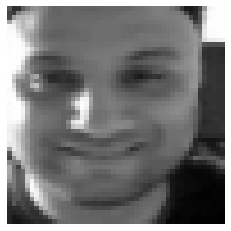

1
6
8210
2304


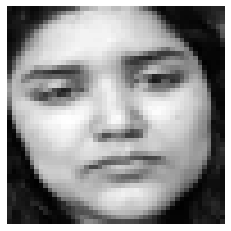

0
7
8083
2304


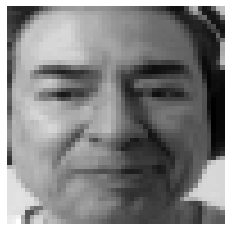

2
8
6911
2304


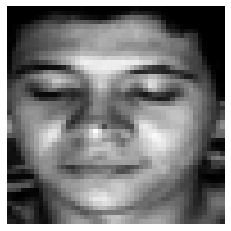

2
9
8538
2304


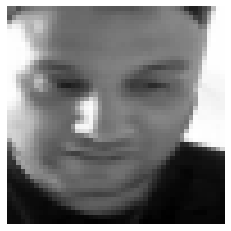

2
10
8216
2304


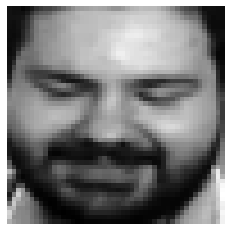

2
11
8074
2304


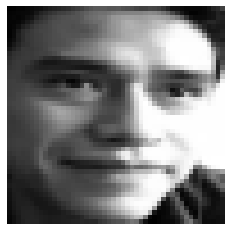

2
12
8114
2304


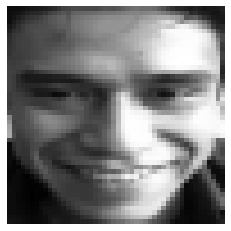

1
13
8067
2304


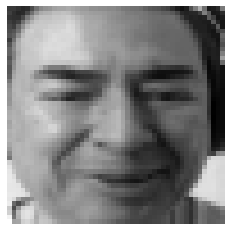

1
14
8550
2304


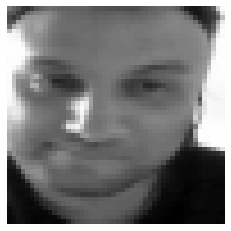

2
15
8220
2304


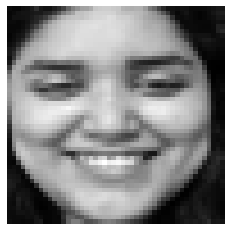

1
16
6911
2304


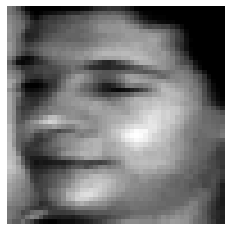

2
17
7917
2304


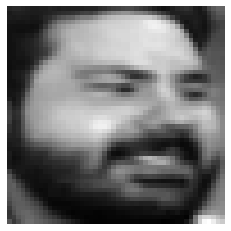

1
18
8168
2304


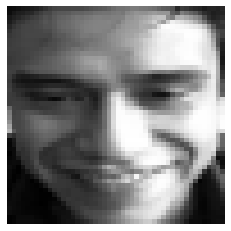

1
19
8028
2304


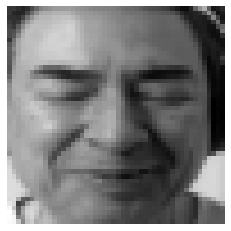

1
20
7567
2304


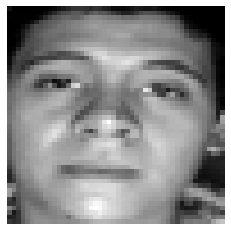

0
21
8282
2304


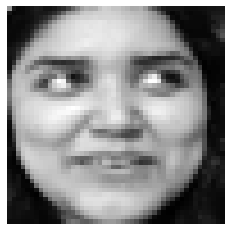

2
22
8494
2304


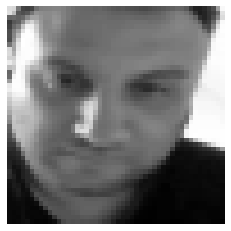

0
23
8127
2304


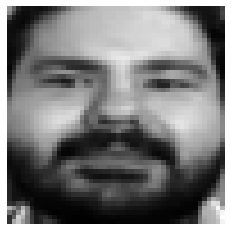

2
24
8022
2304


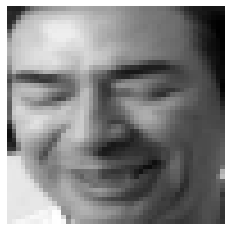

1
25
8114
2304


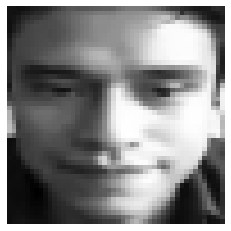

0
26
8500
2304


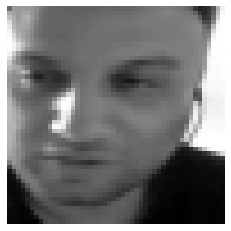

2
27
8213
2304


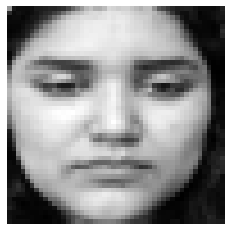

0
28
8077
2304


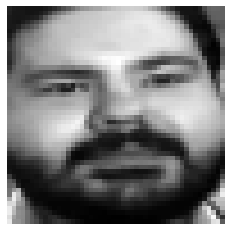

2
29
8282
2304


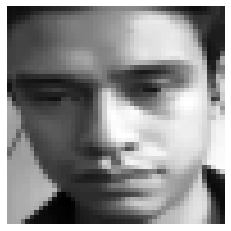

0
30
7978
2304


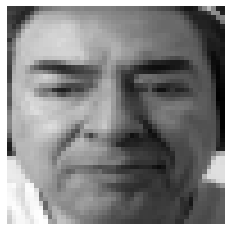

2
31
8088
2304


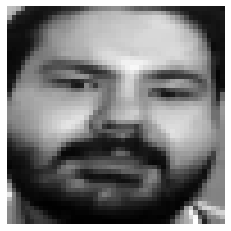

2
32
8197
2304


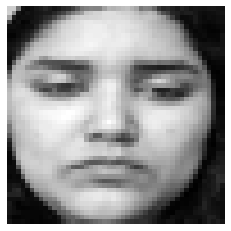

0
33
7770
2304


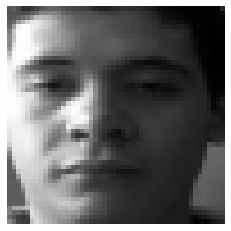

0


In [22]:
emotion_dict = {0: "upset", 1: "happy", 2: "neutral"}

for n in range(0, addon_data.shape[0]):
    print(n)
    lin = addon_data['pixels'][n]
    # print(len(lin))
    img_dt = np.asarray([int(x) for x in lin.split()])  # numpy array
    # print(len(img_dt))
    im = img_dt.reshape((48,48)).astype('uint8')  # 2-d numpy array
    # img = cv2.bitwise_not(img)  # w&b bitwise inverted or do not multiply by 255

    # print(f'ID:{id} \n{clases[clase]}')
    plt.imshow(im, cmap='gray', interpolation='nearest')
    plt.axis('off')
    plt.show()
    a = input()
    addon_data.at[n, 'emotion'] = a

In [24]:
addon_data.head(20)

,emotion,pixels,Usage
0,1,10 10 10 10 10 10 10 10 10 11 14 18 22 24 20 2...,Training
1,1,109 41 28 29 30 30 30 30 31 33 40 52 68 83 94 ...,Training
2,1,61 54 50 47 45 46 50 68 88 103 113 121 127 128...,Training
3,1,33 33 33 33 31 30 31 32 33 37 39 38 38 37 38 3...,Training
4,1,16 17 19 24 25 29 29 39 32 27 31 39 47 63 81 1...,Training
5,1,105 73 75 110 129 146 150 142 133 121 114 115 ...,Training
6,0,24 16 20 25 22 16 17 23 30 35 34 39 42 51 57 7...,Training
7,2,58 50 46 47 46 45 52 72 91 106 118 124 128 128...,Training
8,2,10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 1...,Training
9,2,115 117 90 110 118 126 132 133 134 131 125 117...,Training


In [27]:
addon_data['emotion'].unique()

array(['1', '0', '2'], dtype=object)

In [28]:
Name_addon_data = 'fer2013\\fer2021.csv'
addon_data.to_csv(Name_addon_data, index=False)